In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize 
from scipy.optimize import newton
from scipy import stats
import glob
import os
import pandas as pd
from scipy.stats import gaussian_kde

In [2]:
colors = {
        "dark_purple": "#5F2E88",
        "purple": "#7E59A2",
        "light_purple": "#A17DB8",
        "pale_purple": "#dfd6e5",
        "dark_orange": "#F38227",
        "orange": "#E39943",
        "light_orange": "#EEBA7F",
        "pale_orange": "#f2d4b6",
        "dark_blue": "#3F60AC",
        "blue": "#7292C7",
        "light_blue": "#A5B3CC",
        "pale_blue": "#dae4f1",
        "dark_red": "#9C372F",
        "red": "#C76A6A",
        "light_red": "#E39C9D",
        "pale_red": "#edcccc",
        "dark_green": "#395A34",
        "green": "#688A2F",
        "light_green": "#B3CD86",
        "pale_green": "#d8e2c3",
        "dark_brown": "#764f2a",
        "brown": "#c2996c",
        "light_brown": "#e1bb96",
        "pale_brown": "#efccaf",
        "black": "#444147",
        "light_grey": "#EFEFEF",
        "light_gray": "#EFEFEF",
        "grey": "#6D6F72",
        "gray": "#6D6F72",
}

In [3]:
# Function to generate truncated exponential
def truncated_mean(lam):
    mu=(1/lam-np.exp(-lam)*(1+1/lam))/(1-np.exp(-lam))
    return mu

def equation(lam, given_mu):
    return truncated_mean(lam) - given_mu


def truncated_expo_pdf(x, lmbda):
    return lmbda * np.exp(-lmbda * x) / (1 - np.exp(-lmbda))

def truncated_expo_cdf(x, lmbda):
    return (1 - np.exp(-lmbda * x)) / (1 - np.exp(-lmbda))

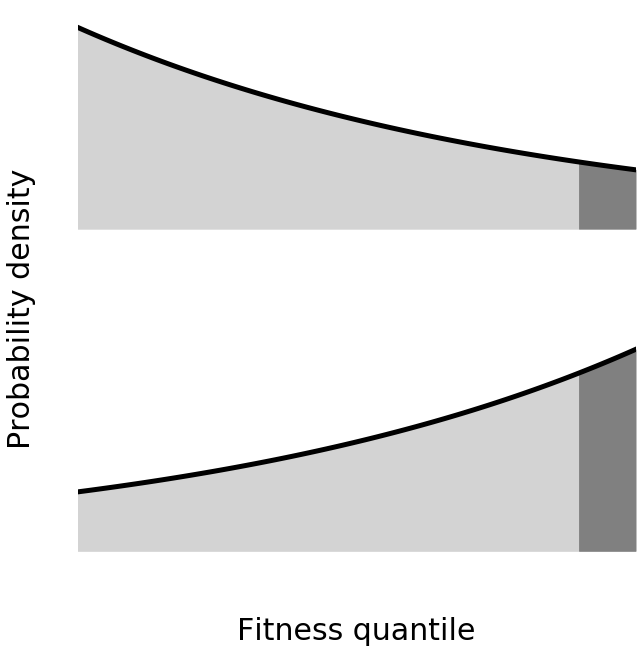

In [4]:
#Figure 3a
lmbda1 = newton(equation, 1, args=(0.4,))
lmbda2 = newton(equation, 1, args=(0.6,))

# Create a new figure and a subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Define trapezoid parameters
trapezoids = [
    {'bottom_width': 1, 'lmbda': lmbda1, 'global_ka_ks': 0.10, 'ki_ks': 0.05,'mu':0.4},
    {'bottom_width': 1, 'lmbda': lmbda2, 'global_ka_ks': 0.10, 'ki_ks': 0.15,'mu':0.6}
]

# Separation line at x=0.9
separation_x = 0.9
edge_width = 5
# Draw trapezoids with exponential top
for i, trap in enumerate(trapezoids):
    # Define the range for the x-axis
    x = np.linspace(0, trap['bottom_width'], 100)
    y = truncated_expo_pdf(x, trap['lmbda'])
    
    # Normalize y to the height of the trapezoid and adjust vertical positioning
    #y_scale = 0.5  # Scale for the height of the trapezoid
    #y_position_offset = 1.0 - i * 0.6  # Adjusted to reduce vertical spacing
    #y = y / max(y) * y_scale + y_position_offset

    # Draw the bottom line of the trapezoid
    #bottom_line_y = y_position_offset

    # Normalize y to the height of the trapezoid
    y_height = (1 - i) * 0.8  # Adjust for vertical positioning
    y = y / max(y) * 0.5 + (1 - i) * 0.8  # Scale and position the trapezoid vertically

    # Draw the bottom line of the trapezoid
    bottom_line_y = (1 - i) * 1.2
    # Find the index where x is approximately 0.9 for separation
    sep_index = np.argmin(np.abs(x - separation_x))
    sep_x = x[sep_index]  # This ensures that we are exactly at the separation point

    # Fill the areas with two different colors
    ax.fill_between(x, y, y_height, where=(x <= sep_x), color='lightgray')
    ax.fill_between(x, y, y_height, where=(x >= sep_x), color='gray')
    # Draw the bottom line of the trapezoid
    #ax.hlines(y_height, x[0], x[-1], color='black')

    # Fill the areas with two different colors
    #ax.fill_between(x[:sep_index], y[:sep_index], y_height, color=colors['light_gray'])
    #ax.fill_between(x[sep_index:], y[sep_index:], y_height, color=colors['gray'])
    # Draw the edges
    ax.plot(x, y, color='black', linewidth=edge_width)
    #ax.hlines(bottom_line_y, x[0], x[-1], color='black', linewidth=edge_width)

    # Annotate the trapezoid with its parameters
    #ax.text(0.4, bottom_line_y + 0.4, f"μ = {trap['mu']}", 
    #        va='bottom', ha='left', fontsize=30)

# Set the limits of the plot
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.35)

# Hide the axes
ax.axis('off')

# Add labels
ax.text(0.5, -0.2, 'Fitness quantile', ha='center', va='center', fontsize=30)
ax.text(-0.1, 0.6, 'Probability density', rotation=90, ha='center', va='center', fontsize=30)
# Display the plot
plt.show()

In [5]:
#Figure 3b
#read in all deep mutational files
np.random.seed(0)
path = '../Data/ProteinGym_substitutions/'
DMS_files=glob.glob(os.path.join(path, '*.csv'))

all_dms=[]
i=0
for f in DMS_files:
    dms=pd.read_csv(f)
    dms['mut_type']=dms['mutant'].str.replace('\d+','')
    dms['mut_type_len']=dms['mut_type'].str.len()
    dms=dms[dms['mut_type_len']==2]
    dms['fit_rank']=dms['DMS_score'].rank(pct=True)
    dms['pid']=i
    most_ties_number=pd.DataFrame(dms.DMS_score.value_counts()).reset_index()['index'][0]
    dms['f_ties']=np.mean(dms['DMS_score']==most_ties_number)
    dms['size']=len(dms)
    dms['mut_type_count']=len(dms.mut_type.unique().tolist())
    all_dms.append(dms)
    i=i+1
all_dms=pd.concat(all_dms)

In [6]:
#look at all pairs
np.random.seed(0)
AA_pairs=all_dms.mut_type.unique().tolist()
pid_for_test=all_dms[all_dms['mut_type_count']==380].pid.unique().tolist()
D=[]
p=[]
sample_size=[]
lambda_list=[]
mu=[]
for ap in AA_pairs:
    data = all_dms[all_dms['mut_type']==ap]
    data_array=np.array(data.fit_rank.tolist())
    sample_size.append(len(data_array))
    given_mu=np.mean(data_array)
    mu.append(given_mu)
    # Extract the lambda parameter that maximizes the likelihood
    lmbda_opt = newton(equation, 1, args=(given_mu,))
    lambda_list.append(lmbda_opt)
    Di,pi=stats.kstest(data_array, truncated_expo_cdf, args=(lmbda_opt,))
    D.append(Di)
    p.append(pi)

In [7]:
df_MLEfit_plot=pd.DataFrame({'mut_type':AA_pairs, 'D':D, 'p':p, 
                             'sample_size':sample_size, 
                             'lmbda':lambda_list,
                             'mu':mu})

df_MLEfit_plot['Bonferroni_p']=df_MLEfit_plot['p']*380

In [8]:
#get Tang's U
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
aa_reachable=pd.read_csv('../Data/Mutally_reachable_aa.csv')
aa_reachable=aa_reachable[['AA1','AA2','U (Universal EI)']]
aa_reachable.columns=['AA1','AA2','U']

aa_reachable['AA1']=aa_reachable['AA1'].str.upper()

aa_reachable['AA2']=aa_reachable['AA2'].str.upper()

AA1=aa_reachable.AA1.tolist()
AA2=aa_reachable.AA2.tolist()
aa1=[]
aa2=[]
for i in range(len(AA1)):
    aa1.append(d[AA1[i]])
    aa2.append(d[AA2[i]])
aa_reachable['aa1']=aa1
aa_reachable['aa2']=aa2

aa_reachable['pair1']=aa_reachable['aa1']+aa_reachable['aa2']
aa_reachable['pair2']=aa_reachable['aa2']+aa_reachable['aa1']

In [9]:
def dynamic_range(c):
    df_MLEfit_plot['dms_exchange']=1-truncated_expo_cdf(c,df_MLEfit_plot['lmbda'])
    aa_reachable_tmp=aa_reachable.merge(df_MLEfit_plot[['mut_type','dms_exchange','mu']],
                                how='left',left_on='pair1',right_on='mut_type')

    aa_reachable_tmp=aa_reachable_tmp.drop(columns='mut_type')
    aa_reachable_tmp=aa_reachable_tmp.rename(columns={'dms_exchange':'Q12',
                                          'mu':'mu12'})
    aa_reachable_tmp=aa_reachable_tmp.merge(df_MLEfit_plot[['mut_type','dms_exchange','mu']],
                                how='left',left_on='pair2',right_on='mut_type')

    aa_reachable_tmp=aa_reachable_tmp.drop(columns='mut_type')
    aa_reachable_tmp=aa_reachable_tmp.rename(columns={'dms_exchange':'Q21',
                                          'mu':'mu21'})
    aa_reachable_tmp['predictU']=(aa_reachable_tmp['Q12']*aa_reachable_tmp['Q21'])/(aa_reachable_tmp['Q12']+aa_reachable_tmp['Q21'])
    return aa_reachable_tmp.predictU.max()/aa_reachable_tmp.predictU.min()

In [10]:
cutoff = np.linspace(0.01,0.99999,100)

In [11]:
dynamic_range_list=[]
for c in cutoff:
    dynamic_range_list.append(dynamic_range(c))

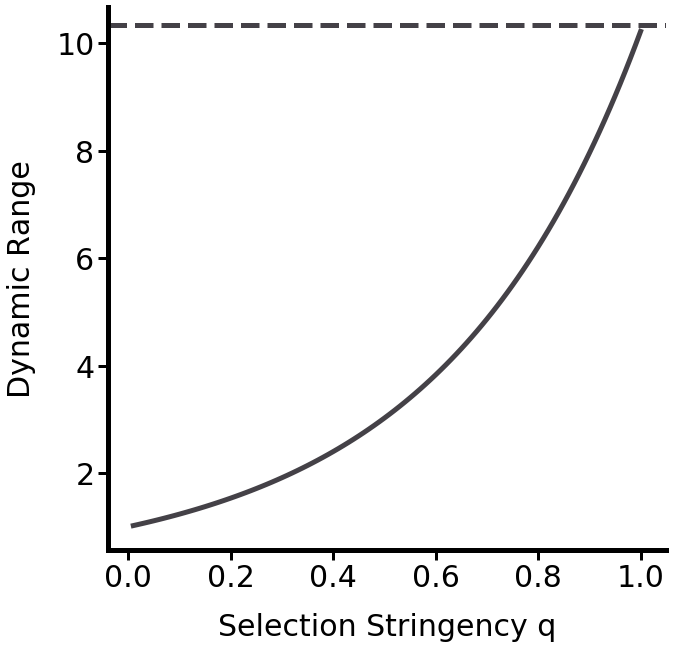

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(cutoff,dynamic_range_list,color=colors['black'],linewidth=5)
# Draw a horizontal line at y=U dynamic range
plt.axhline(y=aa_reachable.U.max()/aa_reachable.U.min(), color=colors['black'], linestyle='--',linewidth=5)
#plt.text(0.8, aa_reachable.U.max()/aa_reachable.U.min()-0.3, 'Dynamic range of Tang\'s U', fontsize=30, va='center', ha='right')
plt.xlabel('Selection Stringency q',fontsize=30,labelpad=20)
plt.ylabel('Dynamic Range',fontsize=30,labelpad=20)
plt.xticks(fontsize=30)        # Adjust tick label size
plt.yticks(fontsize=30)
#plt.legend()
plt.grid(False)
#plt.gca().set_facecolor(colors['light_gray'])
#plt.box(False)
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
# Make ticks thicker, longer, and pointing inward
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=30)

In [13]:
#Fig3c

In [14]:
#read in all deep mutational files
np.random.seed(0)
path = '../Data/ProteinGym_substitutions/'
DMS_files=glob.glob(os.path.join(path, '*.csv'))

all_dms=[]
i=0
for f in DMS_files:
    dms=pd.read_csv(f)
    dms['mut_type']=dms['mutant'].str.replace('\d+','')
    dms['mut_type_len']=dms['mut_type'].str.len()
    dms=dms[dms['mut_type_len']==2]
    dms['fit_rank']=dms['DMS_score'].rank(pct=True)
    dms['pid']=i
    most_ties_number=pd.DataFrame(dms.DMS_score.value_counts()).reset_index()['index'][0]
    dms['f_ties']=np.mean(dms['DMS_score']==most_ties_number)
    dms['size']=len(dms)
    dms['mut_type_count']=len(dms.mut_type.unique().tolist())
    all_dms.append(dms)
    i=i+1
all_dms=pd.concat(all_dms)

In [15]:
#look at all pairs
np.random.seed(0)
AA_pairs=all_dms.mut_type.unique().tolist()
pid_for_test=all_dms[all_dms['mut_type_count']==380].pid.unique().tolist()
D=[]
p=[]
sample_size=[]
lambda_list=[]
mu=[]
for ap in AA_pairs:
    data = all_dms[all_dms['mut_type']==ap]
    data_array=np.array(data.fit_rank.tolist())
    sample_size.append(len(data_array))
    given_mu=np.mean(data_array)
    mu.append(given_mu)
    # Extract the lambda parameter that maximizes the likelihood
    lmbda_opt = newton(equation, 1, args=(given_mu,))
    lambda_list.append(lmbda_opt)
    Di,pi=stats.kstest(data_array, truncated_expo_cdf, args=(lmbda_opt,))
    D.append(Di)
    p.append(pi)

In [16]:
df_MLEfit_plot=pd.DataFrame({'mut_type':AA_pairs, 'D':D, 'p':p, 
                             'sample_size':sample_size, 
                             'lmbda':lambda_list,
                             'mu':mu})

df_MLEfit_plot['Bonferroni_p']=df_MLEfit_plot['p']*380

In [17]:
#get Tang's U
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [18]:
aa_reachable=pd.read_csv('../Data/Mutally_reachable_aa.csv')
aa_reachable=aa_reachable[['AA1','AA2','U (Universal EI)']]
aa_reachable.columns=['AA1','AA2','U']

In [19]:
aa_reachable['AA1']=aa_reachable['AA1'].str.upper()

aa_reachable['AA2']=aa_reachable['AA2'].str.upper()

AA1=aa_reachable.AA1.tolist()
AA2=aa_reachable.AA2.tolist()
aa1=[]
aa2=[]
for i in range(len(AA1)):
    aa1.append(d[AA1[i]])
    aa2.append(d[AA2[i]])
aa_reachable['aa1']=aa1
aa_reachable['aa2']=aa2

aa_reachable['pair1']=aa_reachable['aa1']+aa_reachable['aa2']
aa_reachable['pair2']=aa_reachable['aa2']+aa_reachable['aa1']

#df_MLEfit_plot['dms_exchange']=1-truncated_expo_cdf(0.5,df_MLEfit_plot['lmbda'])
df_MLEfit_plot['dms_exchange']=truncated_expo_pdf(1,df_MLEfit_plot['lmbda'])

aa_reachable=aa_reachable.merge(df_MLEfit_plot[['mut_type','dms_exchange','mu']],
                                how='left',left_on='pair1',right_on='mut_type')

aa_reachable=aa_reachable.drop(columns='mut_type')
aa_reachable=aa_reachable.rename(columns={'dms_exchange':'Q12',
                                          'mu':'mu12'})

In [20]:
aa_reachable=aa_reachable.merge(df_MLEfit_plot[['mut_type','dms_exchange','mu']],
                                how='left',left_on='pair2',right_on='mut_type')

aa_reachable=aa_reachable.drop(columns='mut_type')
aa_reachable=aa_reachable.rename(columns={'dms_exchange':'Q21',
                                          'mu':'mu21'})
aa_reachable['predictU']=(aa_reachable['Q12']*aa_reachable['Q21'])/(aa_reachable['Q12']+aa_reachable['Q21'])
aa_reachable['predictU']=aa_reachable['predictU']/(aa_reachable['predictU'].mean())
aa_reachable['U']=aa_reachable['U']/(aa_reachable['U'].mean())


In [21]:
stats.spearmanr(aa_reachable['U'],
                aa_reachable['predictU'])

SpearmanrResult(correlation=0.8470670259405958, pvalue=9.98919618370427e-22)

In [22]:
stats.pearsonr(aa_reachable['U'],
               aa_reachable['predictU'])

(0.860135767191748, 4.8852135709969523e-23)

In [23]:
x_values=np.array(aa_reachable['predictU'].tolist())
y_values=np.array(aa_reachable['U'].tolist())
# Calculate y_pred based on y=x
y_pred = x_values  # since y = x

# Calculate y_pred based on y=x
y_pred = x_values  # since y = x

# Calculate MSE
MSE = np.mean((y_values - y_pred) ** 2)

print("Mean Squared Error:", MSE)

Mean Squared Error: 0.09453764166529027


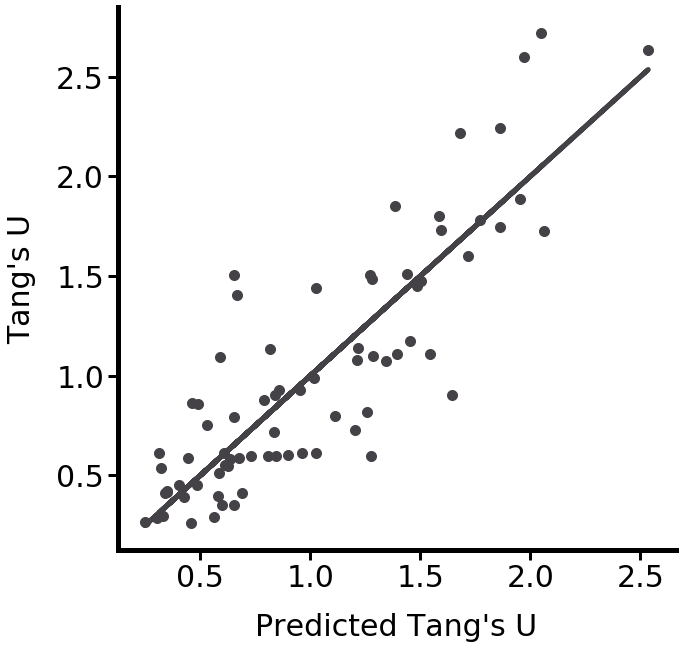

In [24]:
# Create the scatter plot using DataFrame columns directly
plt.figure(figsize=(10, 10))
plt.scatter(aa_reachable['predictU'], aa_reachable['U'], color=colors['black'],s=100)
# Draw a horizontal line at y=0.15
plt.plot(aa_reachable['predictU'], aa_reachable['predictU'], linestyle='-',color=colors['black'],linewidth=5) 


# Setting the title and labels

plt.xlabel('Predicted Tang\'s U',fontsize=30,labelpad=20)
plt.ylabel('Tang\'s U',fontsize=30,labelpad=20)
plt.xticks(fontsize=30)        # Adjust tick label size
plt.yticks(fontsize=30)
#plt.legend()
plt.grid(False)
#plt.gca().set_facecolor(colors['light_gray'])
#plt.legend(fontsize=30)
#plt.box(False)
# Display the plot
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
# Make ticks thicker, longer, and pointing inward
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=30)
plt.show()